# Solution

The amortization schedule generator is solved by utilizing two classes, which is `Mortgage` and `VarMortgage`

## `Mortgage` Class

The `Mortgage` Class is a class used to whole the good ol' fixed rate mortgage. The `p` field is used to hold the mortgage principal, or its present value. The `r` field is used to hold the fixed annual rate across `n` years.

The monthly payment is then generated by `calculate_monthly_payment()` **static** method using the formula
$$monthly\_payment = \frac{p\cdot r\cdot (1 + r)^{n}}{(1 + r)^{n}-1}$$

Amortization schedule of that `Mortgage` object can then be generated using `create_fixed_amortization_schedule()` method, and the schedule generated is stored in the `schedule` field.

`create_var_run_amortization_schedule()` is just a more generalised `create_fixed_amortization_schedule()` method, which can be inherited by `VarMortgage` class to reduce code redundancy.

`plot_payment()` method is then used to generate the principal and interest paid stacked bar chart, adding on remaining balance line plot on the secondary axis for the `Mortgage` object.

## `VarMortgage` Class

It is a child class to `Mortgage`. It holds additional field of lump sum payment (`lumpsum_list`) and annual interest rate (`annual_rate_list`) across the mortgage period. The `annual_compiled_mortgage` is a list composed of `Mortgage` objects for every year across the variable rate mortgage period.

The `create_amortization_schedule()` will run through each year, create the `Mortgage` object for the year, and then append the schedule for that year to `schedule` field. `create_var_run_amortization_schedule()` method of parent class is used to generate the 1-year schedule of the variable mortgage given the remaining period of that `VarMortgage` object.

Similarly, `plot_payment()` method can be called to generate the chart.

## Calculation of Mortgage20, Mortgage30 and Flexi30 (7-1ARM)  

### Mortgage20 and Mortgage30  

Both of these are just fixed rate mortgage with just different rate and length of mortgage.  

The calculation of monthly payment is using the `calculate_monthly_payment()` method of `Mortgage` class explained above. Then the calculation of monthly interest paid and principal paid are straightforward:
$$interest\_paid=p\cdot monthly\_r$$
$$principal\_paid=monthly\_payment - interest\_paid$$

### Flexi30  

It is the variable rate mortgage 7-1ARM.

#### Computation  

The variable rate is obtained from the historical data from **1992 January to 2021 December**. The monthly rate is obtained while averaging the weekly rate provided in the CSV files. The first 7 years (84 months) are the locked in period, where the annual interest rate is locked in at 4.50%.During the locked in period, the borrower is not allowed to pay lump sum in full in order for the bank to earn a certain amount of interest before closing the mortgage.

#### Selection of 4.5% initial rate  

The period length is similar to Mortgage30, which is 30 years, hence the rate should be close to 4%. Given the flexiblity given to the borrower, the bank will ask for higher rate, which presumably 0.5% more, hence the 4.5%. The subsequent year after the locked in period, the rate will vary according to the market itself. The remaining calculations will be the same as fixed rate and term mortgage shown, except **borrower is allowed to pay a lump sum to reduce loan present value**.



In [1]:
import pandas as pd
#import matplotlib.pyplot as plt
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta

# To display pandas dataframe cells with float data in 4 decimal places
pd.options.display.float_format = '{:.4f}'.format

In [2]:
class Mortgage(object):
    def __init__(self, principal, annual_rate, num_years):
        """Create a new Mortgage object
        
        Arguments:
        principal - Principal or starting amount of a mortgage
        annual_rate - Annual interest rate in decimal form, i.e. 0.04 instead of 4%
        num_years - Tenure of the mortgage
        """
        self.p = principal
        self.r = annual_rate
        self.n = num_years
        
        self.balance = principal
        self.schedule = pd.DataFrame(columns=["Month", "Payment", "InterestPaid", "PrincipalPaid", "Balance"])
        
    def calculate_monthly_payment(mortgage):
        """Static method to calculate fixed monthly payment
        
        Arguments:
        mortgage - A mortgage object
        """
        num_months = mortgage.n * 12
        monthly_rate = mortgage.r / 12
        monthly_payment = (mortgage.p * monthly_rate * (1 + monthly_rate) ** num_months) / ((1 + monthly_rate) ** num_months - 1)
        return monthly_payment
    

    def create_fixed_amortization_schedule(self, start_date):
        """Instance method to create monthly schedule of fixed amortization
        
        Side Effects:
        Modify self.balance and self.schedule
        """
        return self.create_var_run_amortization_schedule(start_date, calc_for_n_years = self.n)

    
    def create_var_run_amortization_schedule(self, start_date, calc_for_n_years = 1):
        """Instance method to create monthly schedule for specific length of years < mortgage tenure
        
        Arguments:
        calc_for_n_years - Number of years for the schedule to be calculated to
        
        Side Effects:
        Modify self.balance and self.schedule
        """
        balance = self.p
        monthly_rate = self.r / 12
        monthly_payment = Mortgage.calculate_monthly_payment(self)

        for month in range(1, calc_for_n_years * 12 + 1):
            interest = balance * monthly_rate
            payment = monthly_payment
            if payment > balance + interest:
                payment = balance + interest
            principal_paid = payment - interest
            balance -= principal_paid
            
            # With a tolerance of 1e-6, balance lower than that is considered effectively zero
            if balance < 0.000001:
                balance = 0
                
            # Create a row entry in the schedule
            row = pd.DataFrame({"Month": [month], "Payment": [payment], "InterestPaid": [interest], "PrincipalPaid": [principal_paid], "Balance": [balance]})
            self.schedule = pd.concat([self.schedule, row])
            self.balance = balance
        
        # Creating a Date Column
        self.schedule["Date"] = [start_date + relativedelta(months=i) for i in range(0, calc_for_n_years * 12)]
        self.schedule = self.schedule.reset_index(drop=True)
        return self
    
    def plot_payment(self, title):
        """Instance method to plot the amortization payment schedule
        
        Arguments:
        title - Plot title
        
        Visualization:
            Combo Chart:
                Stacked Bar Chart - Principal and Interest Paid
                Line Cha - Remaining Balance        
        """
        ax = self.schedule[["PrincipalPaid", "InterestPaid"]].plot.bar(stacked=True)        
        ax2 = self.schedule[["Balance"]].plot.line(ax = ax, secondary_y=True, title = title, color = 'red')
        ax2.set_ylim(0, self.p)
        
        bars, labels = ax.get_legend_handles_labels()
        bars2, labels2 = ax2.get_legend_handles_labels()
        ax.get_legend().remove()

        ax2.legend(bars + bars2, labels + labels2, loc=0)
        ax.set_xlabel("Month")
        ax.set_ylabel("Interest or Principal Paid")
        ax2.set_ylabel("Remaining Balance")


        
        


In [3]:
class VarMortgage(Mortgage):
    def __init__(self, principal, num_years, annual_rate_list, lumpsum_list=None):
        """Initialize a VarMortgage object
        
        Arguments:
        principal - Principal or starting amount of a mortgage
        num_years - Tenure of the mortgage
        annual_rate_list - A list of decimal annual interest rate, which its length = num_years
        lumpsum_list - A list of lump sum paid, which if supplied, its length = num_years
        
        Throw:
        ValueError - If length of annual_rate_list and lumpsum_list are not equal to num_years
        TypeError - If elements of annual_rate_list are not float; elements of lumpsum_list are not numeric
        """
        if len(annual_rate_list) != num_years:
            raise ValueError("Lenght of annual_rate_list must match num_years!") 
        if lumpsum_list is not None and len(lumpsum_list) != num_years:
            raise ValueError("Lenght of lumpsum_list must match num_years!") 
        if not all([isinstance(x, float) for x in annual_rate_list]):
            raise TypeError("Elements in annual_rate_list must be float, in decimal form instead of percentage form")
        if lumpsum_list is not None and  not all([isinstance(x, float) or isinstance(x, int) for x in lumpsum_list]):
            raise TypeError("Elements in lumpsum_list must be int or float")
            
        self.p = principal
        self.n = num_years
        self.annual_rate_list = annual_rate_list
        self.lumpsum_list = [0.0] * num_years if lumpsum_list is None else lumpsum_list
        
        # Array of annual Mortgage Object
        self.annual_compiled_mortgage = [None] * num_years        
        self.balance = principal
        self.remaining_n = num_years
        self.schedule = pd.DataFrame(columns=["Month", "Payment", "LumpSum", "InterestRate", "InterestPaid", "PrincipalPaid", "Balance"])
    
    def create_amortization_schedule(self, start_date):
        """Instance method which create monthly schedule of amortization
        
        Arguments:
        start_date - Starting date of the mortgage
        
        Side Effects:
        Modify self.balance, self.annual_compiled_mortgage, self.remaining_n, and self.schedule
        """        
        for year in range(0, self.n):
            # Create an annual Mortgage Object based on previous year's balance deducted by lump sum paid
            self.annual_compiled_mortgage[year] = Mortgage(self.balance - self.lumpsum_list[year], self.annual_rate_list[year], self.remaining_n)
            
            # Create a DataFrame of schedule for the year and append in the main schedule DataFrame
            annual_schedule = self.annual_compiled_mortgage[year].create_var_run_amortization_schedule(start_date + relativedelta(years=year)).schedule
            annual_schedule["LumpSum"] = self.lumpsum_list[year]
            annual_schedule["InterestRate"] = self.annual_rate_list[year]
            self.schedule = pd.concat([self.schedule, annual_schedule])
            
            self.remaining_n -= 1
            self.balance = self.annual_compiled_mortgage[year].balance
        
        # Correcting the Month column, else it will be 1..12 repeated by num_years times
        self.schedule["Month"] = list(range(1, self.n * 12 + 1))
        
        self.schedule = self.schedule.reset_index(drop=True)
        return self
            
            

In [4]:
mortgage30 = Mortgage(1_000_000, 0.04, 30)
mortgage30.create_fixed_amortization_schedule(start_date = datetime.date(1992,1,1)).schedule

,Month,Payment,InterestPaid,PrincipalPaid,Balance,Date
0,1,4774.1530,3333.3333,1440.8196,998559.1804,1992-01-01
1,2,4774.1530,3328.5306,1445.6224,997113.5580,1992-02-01
2,3,4774.1530,3323.7119,1450.4411,995663.1169,1992-03-01
3,4,4774.1530,3318.8771,1455.2759,994207.8410,1992-04-01
4,5,4774.1530,3314.0261,1460.1268,992747.7142,1992-05-01
...,...,...,...,...,...,...
355,356,4774.1530,78.7797,4695.3733,18938.5282,2021-08-01
356,357,4774.1530,63.1284,4711.0245,14227.5036,2021-09-01
357,358,4774.1530,47.4250,4726.7279,9500.7757,2021-10-01
358,359,4774.1530,31.6693,4742.4837,4758.2920,2021-11-01


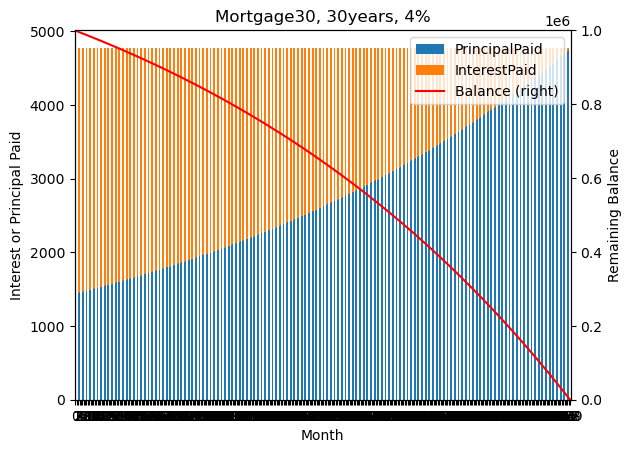

In [5]:
mortgage30.plot_payment("Mortgage30, 30years, 4%")

In [6]:
mortgage20 = Mortgage(1_000_000, 0.025, 20)
mortgage20.create_fixed_amortization_schedule(start_date = datetime.date(1992,1,1)).schedule

,Month,Payment,InterestPaid,PrincipalPaid,Balance,Date
0,1,5299.0289,2083.3333,3215.6956,996784.3044,1992-01-01
1,2,5299.0289,2076.6340,3222.3950,993561.9094,1992-02-01
2,3,5299.0289,2069.9206,3229.1083,990332.8012,1992-03-01
3,4,5299.0289,2063.1933,3235.8356,987096.9656,1992-04-01
4,5,5299.0289,2056.4520,3242.5769,983854.3886,1992-05-01
...,...,...,...,...,...,...
235,236,5299.0289,54.8549,5244.1740,21086.1776,2011-08-01
236,237,5299.0289,43.9295,5255.0994,15831.0782,2011-09-01
237,238,5299.0289,32.9814,5266.0475,10565.0307,2011-10-01
238,239,5299.0289,22.0105,5277.0184,5288.0122,2011-11-01


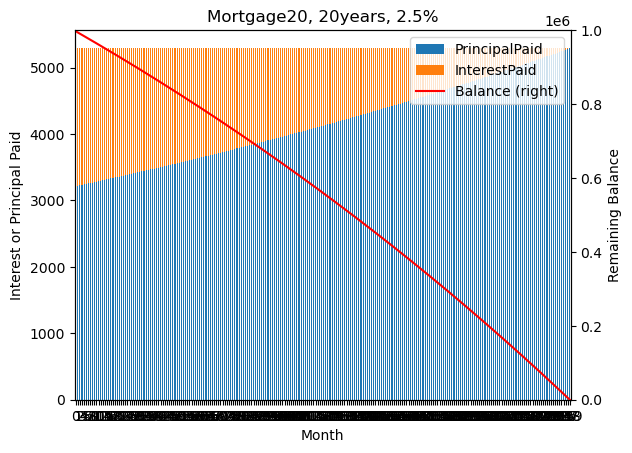

In [7]:
mortgage20.plot_payment("Mortgage20, 20years, 2.5%")

In [8]:
rate = pd.read_csv("rate.csv")
flexi_rate = rate["Rate"].values

flexi30 = VarMortgage(1_000_000, 30, flexi_rate)
flexi30.create_amortization_schedule(start_date = datetime.date(1992,1,1)).schedule

,Month,Payment,LumpSum,InterestRate,InterestPaid,PrincipalPaid,Balance,Date
0,1,5066.8531,0.0000,0.0450,3750.0000,1316.8531,998683.1469,1992-01-01
1,2,5066.8531,0.0000,0.0450,3745.0618,1321.7913,997361.3556,1992-02-01
2,3,5066.8531,0.0000,0.0450,3740.1051,1326.7480,996034.6076,1992-03-01
3,4,5066.8531,0.0000,0.0450,3735.1298,1331.7233,994702.8843,1992-04-01
4,5,5066.8531,0.0000,0.0450,3730.1358,1336.7173,993366.1670,1992-05-01
...,...,...,...,...,...,...,...,...
355,356,5276.5477,0.0000,0.0265,57.8779,5218.6698,20990.1796,2021-08-01
356,357,5276.5477,0.0000,0.0265,46.3533,5230.1944,15759.9852,2021-09-01
357,358,5276.5477,0.0000,0.0265,34.8033,5241.7444,10518.2408,2021-10-01
358,359,5276.5477,0.0000,0.0265,23.2278,5253.3199,5264.9210,2021-11-01


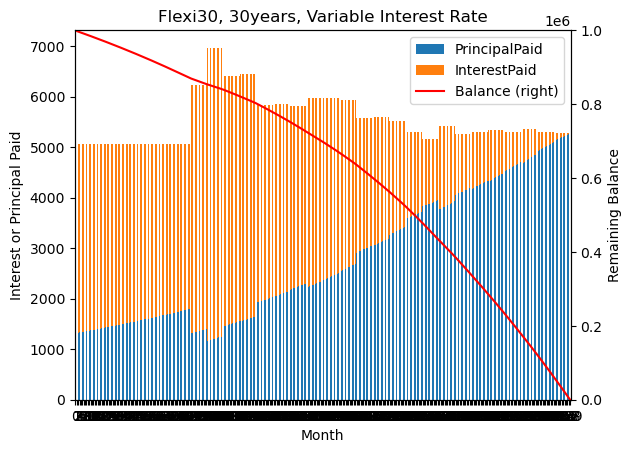

In [9]:
flexi30.plot_payment("Flexi30, 30years, Variable Interest Rate")